<a href="https://colab.research.google.com/github/yashashvisri/Brain-Tumor-Detection/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip", "r")
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import os
import numpy as np
import random

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
#shuffeling training data
training_dir = '/content/dataset/Training'
testing_dir= '/content/dataset/Testing'

train_paths = []
train_lables = []

for label in os.listdir(training_dir):
  for image in os.listdir(os.path.join(training_dir, label)):
    train_paths.append(os.path.join(training_dir, label, image))
    train_lables.append(label)

train_paths, train_lables = shuffle(train_paths, train_lables)
train_paths




['/content/dataset/Training/meningioma/Tr-me_1222.jpg',
 '/content/dataset/Training/notumor/Tr-no_0975.jpg',
 '/content/dataset/Training/meningioma/Tr-me_0310.jpg',
 '/content/dataset/Training/glioma/Tr-gl_0914.jpg',
 '/content/dataset/Training/meningioma/Tr-me_1056.jpg',
 '/content/dataset/Training/meningioma/Tr-me_1187.jpg',
 '/content/dataset/Training/notumor/Tr-no_1380.jpg',
 '/content/dataset/Training/glioma/Tr-gl_0843.jpg',
 '/content/dataset/Training/pituitary/Tr-pi_0876.jpg',
 '/content/dataset/Training/notumor/Tr-no_1375.jpg',
 '/content/dataset/Training/pituitary/Tr-pi_1224.jpg',
 '/content/dataset/Training/meningioma/Tr-me_0738.jpg',
 '/content/dataset/Training/glioma/Tr-gl_1233.jpg',
 '/content/dataset/Training/glioma/Tr-gl_0681.jpg',
 '/content/dataset/Training/meningioma/Tr-me_0105.jpg',
 '/content/dataset/Training/meningioma/Tr-me_0074.jpg',
 '/content/dataset/Training/glioma/Tr-gl_0314.jpg',
 '/content/dataset/Training/meningioma/Tr-me_0198.jpg',
 '/content/dataset/Trai

In [ ]:
#shuffeling testing data
training_dir = '/content/dataset/Training'
testing_dir= '/content/dataset/Testing'

test_paths = []
test_lables = []

for label in os.listdir(testing_dir):
  for image in os.listdir(os.path.join(testing_dir, label)):
    test_paths.append(os.path.join(testing_dir, label, image))
    test_lables.append(label)

test_paths, test_lables = shuffle(test_paths, test_lables)
test_paths



['/content/dataset/Testing/notumor/Te-no_0300.jpg',
 '/content/dataset/Testing/glioma/Te-gl_0279.jpg',
 '/content/dataset/Testing/glioma/Te-gl_0047.jpg',
 '/content/dataset/Testing/notumor/Te-no_0261.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0040.jpg',
 '/content/dataset/Testing/glioma/Te-gl_0230.jpg',
 '/content/dataset/Testing/notumor/Te-no_0227.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0221.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0266.jpg',
 '/content/dataset/Testing/notumor/Te-no_0127.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0218.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0254.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0251.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0303.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0076.jpg',
 '/content/dataset/Testing/pituitary/Te-pi_0180.jpg',
 '/content/dataset/Testing/glioma/Te-gl_0209.jpg',
 '/content/dataset/Testing/meningioma/Te-me_0072.jpg',
 '/content/dataset/Testing/notumor/Te-no_0

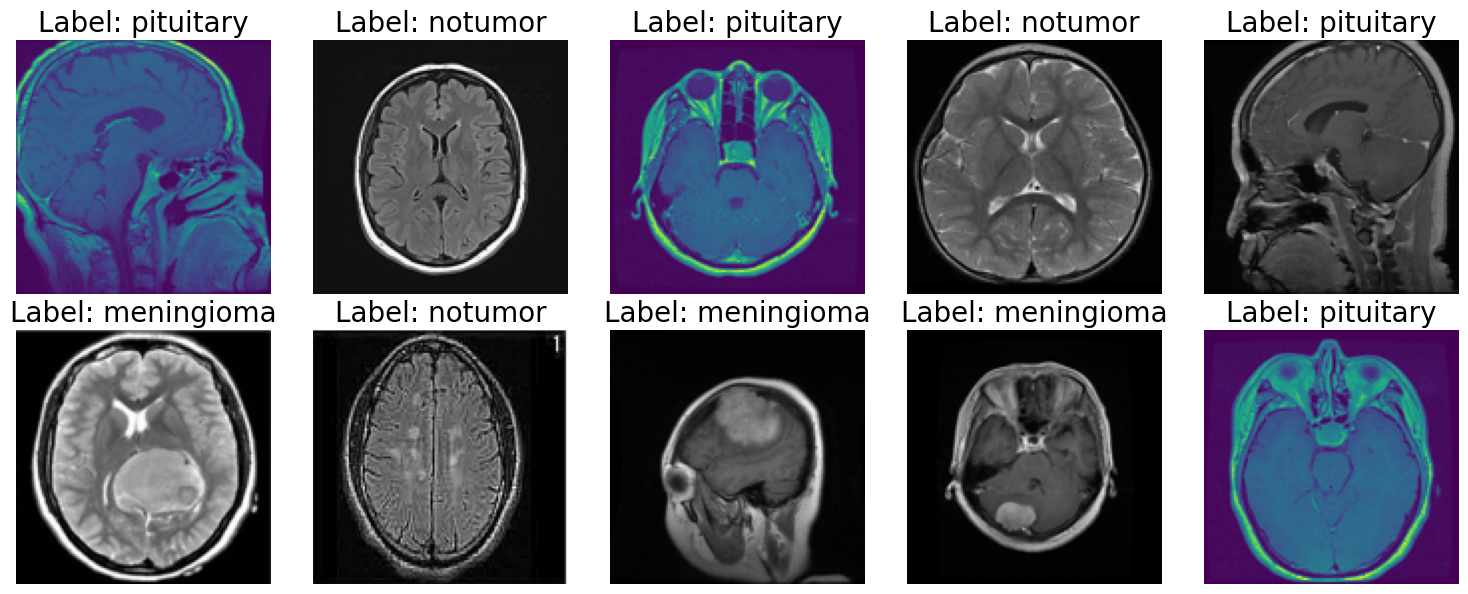

In [ ]:
#Data Visualization
import random
import matplotlib.pyplot as plt

#selecting random indcies of images
random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2,5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):

  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis("off")
  axes[i].set_title(f"Label: {train_lables[idx]}", fontsize =20)

plt.tight_layout()
plt.show()








In [ ]:
def augemnt_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image



def open_images(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = augemnt_image(img)
    images.append(img)
  return np.array(images)

def encode_label(labels):
  unique_label = os.listdir(training_dir)
  encoded = [unique_label.index(label) for label in labels]
  return encoded

def data_gen(paths, label, batch_size = 12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = label[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, np.array(batch_labels)

In [ ]:
# Model Architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top= False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable =  False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(len(os.listdir(training_dir)), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10

history = model.fit(
    data_gen(train_paths, train_lables, batch_size=batch_size, epochs = epochs),epochs = epochs,
    steps_per_epoch = steps)

Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.7522
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.2446 - sparse_categorical_accuracy: 0.9102
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9382
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9588
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.0950 - sparse_categorical_accuracy: 0.9605
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9828
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9870
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9858
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9855
Epoch 10/10
285/285 ━━━━━━━━━━━━━━━━━

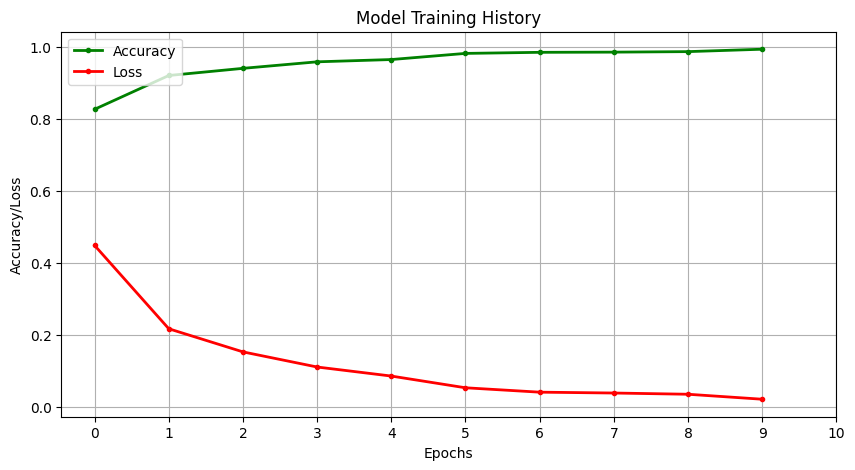

In [ ]:
# Ploting Training History
plt.figure(figsize=(10, 5))
plt.grid(True)

plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.xticks(range(0, epochs+1))
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels = encode_label(test_lables)

test_predictions = model.predict(test_images)


print(classification_report(test_labels, np.argmax(test_predictions, axis=1)))



41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       405
           1       0.97      0.99      0.98       300
           2       0.99      0.94      0.96       300
           3       0.94      0.95      0.95       306

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



[[405   0   0   0]
 [  0 298   0   2]
 [  2   0 281  17]
 [  2   8   4 292]]


Text(95.72222222222221, 0.5, 'True Labels')

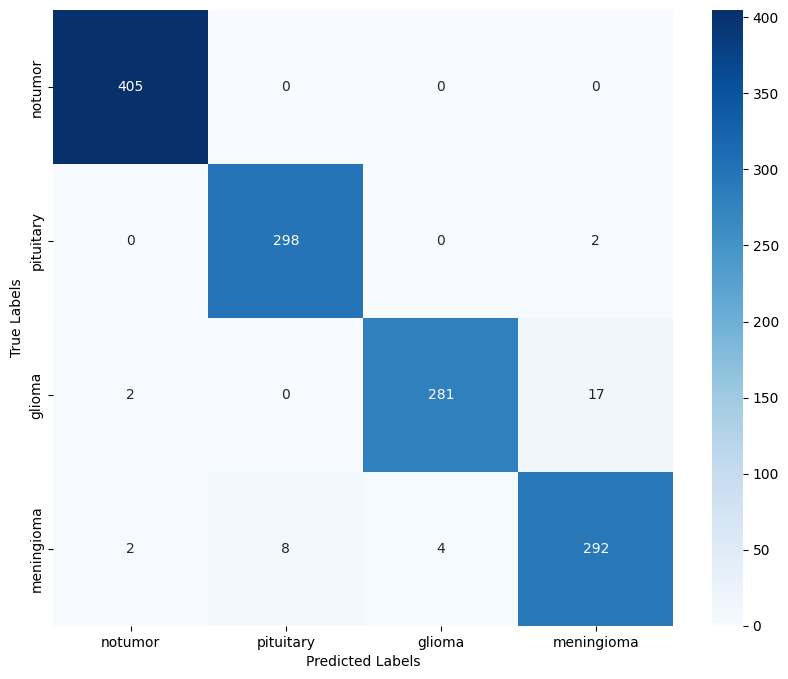

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


cm = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))
plt.figure(figsize=(10, 8))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(training_dir), yticklabels=os.listdir(training_dir))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

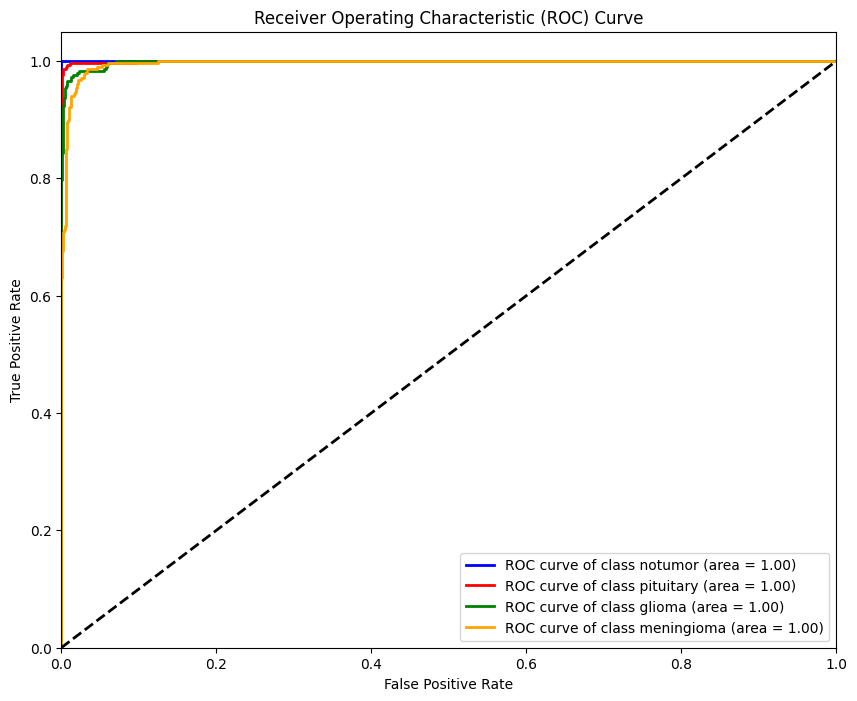

In [ ]:
# roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import os

# Binarize the test labels
num_classes = len(os.listdir(training_dir))
test_labels_binarized = label_binarize(test_labels, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange'] # Define colors for each class
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(os.listdir(training_dir)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()